In [1]:
import time
import scipy
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles
from IPython.display import clear_output

x shape: (500, 2)
y shape: (500, 1)


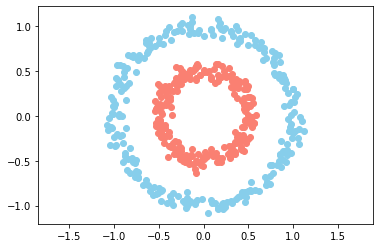

In [2]:
n = 500 # numero de registros
p = 2 # numero de columnas (features)
ci_dist = 0.5 # distancia entre circulos

X, Y = make_circles(n_samples=n, factor=ci_dist, noise=0.05) # X matriz de features (coordenadas). Y matriz de binarios, (variable target)
Y = Y[:, np.newaxis]
print("x shape:", X.shape)
print("y shape:", Y.shape)
plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], c="skyblue")
plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], c="salmon")
plt.axis("equal")
plt.show()

In [3]:
# definimos una clase para crear capas de la red neuronal, a esto le llamamos "objeto":
class neural_layer():
    
    def __init__(self, num_connexions, num_neurons, activation_function):
        
        # variables para re-escalar las variables "bias" y "W"
        rescale = 2
        center = 1
        
        # el objeto recibirá la función de activación deseada (sigmoide, relu.
        self.activation_function = activation_function
        
        # el entrenamiento inicial (antes del gradiente) será aleatorio gracias a estas dos variables:
        self.bias = np.random.rand(1, num_neurons) * rescale - center
        self.W = np.random.rand(num_connexions, num_neurons) * rescale - center

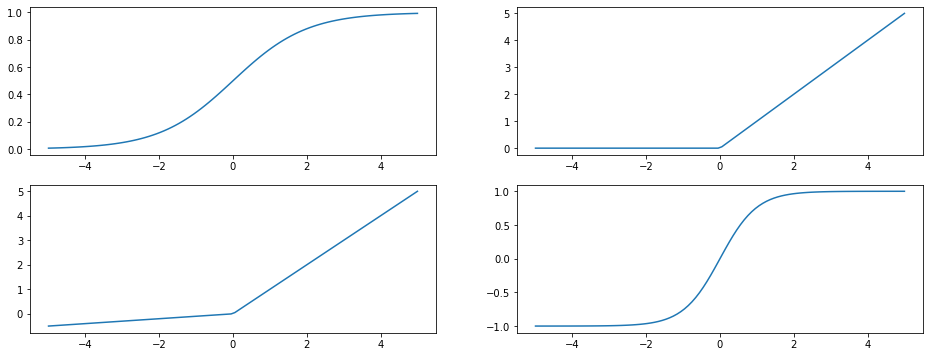

In [4]:
# creamos las funciones de activacion (función anónima "lambda"):
activation_f = {
    "sigmoidal": lambda x: 1 / (1 + np.e ** (-x)),
    "sigmo_deriv": lambda x: x * (1 - x),
    "relu": lambda x: np.maximum(0, x),
    "leaky_relu": lambda x: np.maximum(0.1 * x, x),
    "tanh": lambda x: (2 / (1 + np.e ** (-2 * x))) - 1
}

# visualicemos el comportamiento de la función:
_x = np.linspace(-5, 5, 100)
fig = plt.figure(figsize=(16, 6))
axes = fig.subplots(nrows=2, ncols=2)
axes[0, 0].plot(_x, activation_f["sigmoidal"](_x), label="Sigmoidal")
axes[0, 1].plot(_x, activation_f["relu"](_x), label="ReLU")
axes[1, 0].plot(_x, activation_f["leaky_relu"](_x), label="Leaky ReLU")
axes[1, 1].plot(_x, activation_f["tanh"](_x), label="Hyperbolic Tangent")
plt.show()

In [5]:
def create_neural_net(topology, activation_function):
    neural_net = []
    for l, layer in enumerate(topology[:-1]):
        neural_net.append(neural_layer(topology[l], topology[l+1], activation_function))
        
    return neural_net

In [6]:
# la ultima capa solo tiene una neurona pues queremos resolver un problema de [0, 1]:
topology = [p, 4, 8, 1]
neural_net = create_neural_net(topology=topology, activation_function=activation_f)

In [7]:
cost_function = {
    "sme": lambda Y_predict, Y_real: np.mean((Y_predict - Y_real) ** 2),
    "sme_deriv": lambda Y_predict, Y_real: (Y_predict - Y_real)
}

In [8]:
def _forward_propagation(neural_net, X, Y, cost_f, act_f):
    
    out_put = [(None, X)]
    
    # forward pass:
    for l, layer in enumerate(neural_net):
        weighted_sum = out_put[-1][1] @ neural_net[l].W + neural_net[l].bias # suma ponderada que se ejecuta en la primera capa
        activation = neural_net[l].activation_function[act_f](weighted_sum)
        out_put.append((weighted_sum, activation))
    #print("Feed Forward Propagation Error", "[", cost_f, "]:", cost_function[cost_f](out_put[-1][1], Y))
    
    return out_put

In [9]:
def _gradient_descent(neural_net, l, out_put, deltas, learn_r):
    neural_net[l].bias = neural_net[l].bias - np.mean(deltas[0], axis=0, keepdims=True) * learn_r
    neural_net[l].W = neural_net[l].W - out_put[l][1].T @ deltas[0] * learn_r
    
    return out_put

In [ ]:
def _back_propagation(neural_net, Y, out_put, cost_f, act_f, learn_r):
    
    deltas = []
    
    # backward pass:
    for l in reversed(range(0, len(neural_net))):
        weighted_sum = out_put[l+1][0]
        activation = out_put[l+1][1]
        
        # back-propagation algorithm:
        if l == len(neural_net) - 1:
            deltas.insert(0, cost_function[cost_f](activation, Y) * neural_net[l].activation_function[act_f](activation))
        else:
            deltas.insert(0, deltas[0] @ W_vector.T * neural_net[l].activation_function[act_f](activation))
        W_vector = neural_net[l].W
        
        _gradient_descent(neural_net=neural_net, l=l, out_put=out_put, deltas=deltas, learn_r=learn_r)
    
    return out_put

In [ ]:
def train(neural_net, X, Y, cost_f, act_f, learn_r=0.05, train=True):
    
    # iniciamos con el entrenamiento hacia adelante:
    _feed_forward_output = _forward_propagation(
        neural_net=neural_net, 
        X=X, 
        Y=Y, 
        cost_f=cost_f, 
        act_f=act_f,
    )
    
    if train:
        # seguimos con el entrenamiento hacia atrás:
        _back_propagation(
            neural_net=neural_net,
            Y=Y, 
            out_put=_feed_forward_output, 
            cost_f="sme_deriv", 
            act_f="sigmo_deriv",
            learn_r=learn_r
        )
    
    return _feed_forward_output[-1][1]

In [ ]:
# ejecutemos una prueba del método "train()"
train(
    neural_net=neural_net, 
    X=X, 
    Y=Y, 
    cost_f="sme", 
    act_f="sigmoidal"
)

In [ ]:
neural_n = create_neural_net(topology, activation_f)
loss = []

for i in range(1000):
    predict_Y = train(neural_n, X, Y, cost_function, "sigmoidal", learn_r=0.05)
    if i % 25 == 0:
        loss.append(cost_function["sme"](predict_Y, Y))
        res = 50

        _x0 = np.linspace(-1.5, 1.5, res)
        _x1 = np.linspace(-1.5, 1.5, res)

        _Y = np.zeros((res, res))
        for i0, x0 in enumerate(_x0):
            for i1, x1 in enumerate(_x1):
                _Y[i0, i1] = train(neural_n, np.array([[x0, x1]]), Y, cost_function, "sigmoidal", train=False)[0][0]

        plt.pcolormesh(_x0, _x1, _Y, cmap="coolwarm")
        plt.axis("equal")

        plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], c="skyblue")
        plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], c="salmon")

        clear_output(wait=True)
        plt.show()
        plt.plot(range(len(loss)), loss)
        plt.show()
        time.sleep(0.5)